In [22]:
# the first segment is to load the data

import os
import tarfile
import pandas as pd
from six.moves import urllib

DOWNLOAD_ROOT = "http://raw.girhubusercontent.com/ageron/handsom-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.join(housing_path, "housing.tgz"):
        tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing.tgz.extracall(path=housing_path)
    housing.tgz.close()
    

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


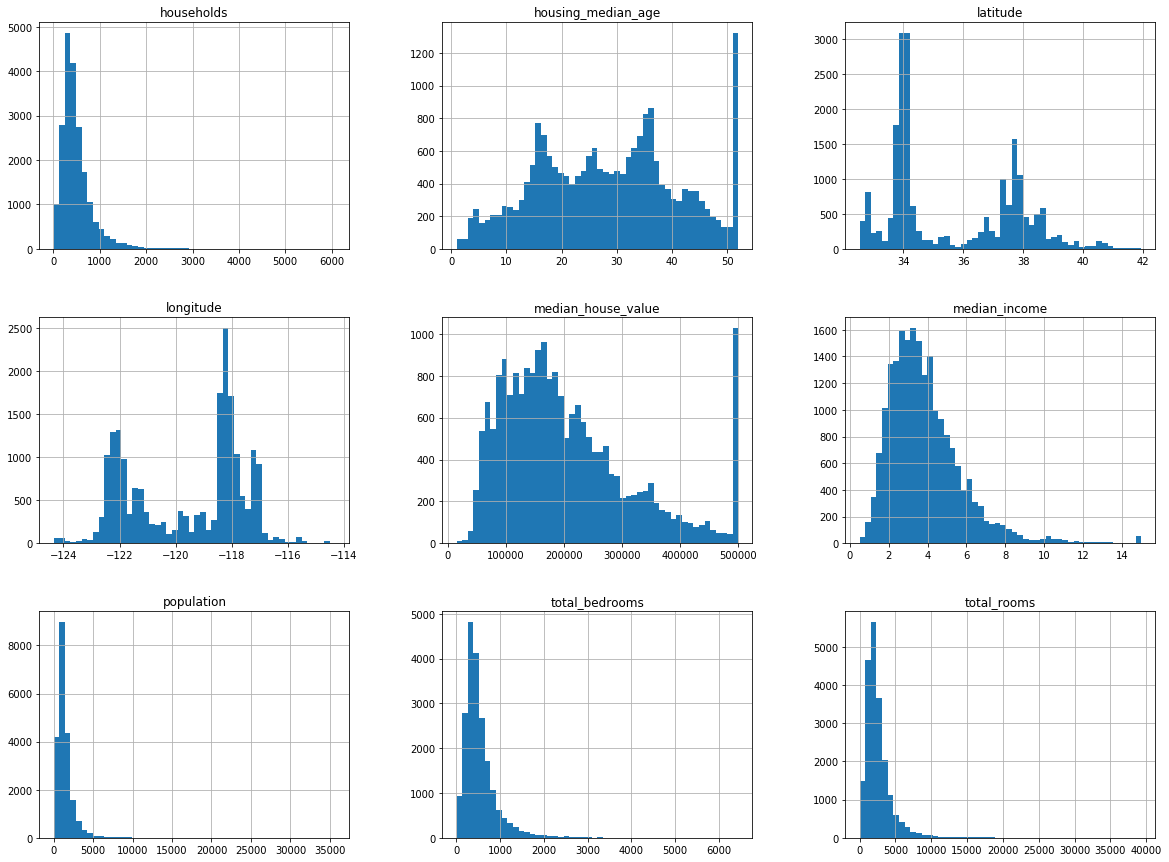

In [23]:
# This segment does a first pass at visualization of the data
display(housing.describe())

%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()


In [24]:
# Second separate training and test set 
import numpy as np

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [25]:
# Third segment cleans data: attribute adding, categorical encoding, scaling
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
#from sklearn.preprocessing import Imputer as SimpleImputer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer



rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

housing2 = housing.copy()
housingcomp = housing2.drop("median_house_value", axis=1)
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

housing_num = housing.drop("ocean_proximity", axis=1)

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)


In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

display(grid_search.best_params_)
display(grid_search.best_estimator_)

cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

{'max_features': 6, 'n_estimators': 30}

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

62867.02652201218 {'max_features': 2, 'n_estimators': 3}
55925.289047626684 {'max_features': 2, 'n_estimators': 10}
52927.10523072989 {'max_features': 2, 'n_estimators': 30}
60570.20070475335 {'max_features': 4, 'n_estimators': 3}
53051.09612178749 {'max_features': 4, 'n_estimators': 10}
50631.63483800771 {'max_features': 4, 'n_estimators': 30}
58570.363777433384 {'max_features': 6, 'n_estimators': 3}
52185.7854162127 {'max_features': 6, 'n_estimators': 10}
50058.88086972692 {'max_features': 6, 'n_estimators': 30}
59256.49210392182 {'max_features': 8, 'n_estimators': 3}
52383.106037992904 {'max_features': 8, 'n_estimators': 10}
50350.96420055072 {'max_features': 8, 'n_estimators': 30}
62713.477182374525 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54885.862788505314 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60328.60119797167 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53000.11514915953 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [27]:
# Fifth segment, display results 

#First list the scores of your attributes

feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_er_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

#Next we'll generate side by side plots of the real data 
#as well as the projected data

[(0.31874787138076033, 'median_income'),
 (0.15582314013439097, 'INLAND'),
 (0.1065283814092573, 'pop_er_hhold'),
 (0.07849683928834345, 'longitude'),
 (0.07196959539424946, 'rooms_per_hhold'),
 (0.06759985186611359, 'latitude'),
 (0.06541488874823419, 'bedrooms_per_room'),
 (0.04341717029880474, 'housing_median_age'),
 (0.01780345605181054, 'total_rooms'),
 (0.01745425928376587, 'total_bedrooms'),
 (0.01723373756416812, 'population'),
 (0.016532574259595166, '<1H OCEAN'),
 (0.016110583332956334, 'households'),
 (0.0034756943889915157, 'NEAR BAY'),
 (0.0033107786411770766, 'NEAR OCEAN'),
 (8.117795738129864e-05, 'ISLAND')]

In [28]:
# Now we run the model on the test data to validate the model 

from sklearn.metrics import mean_squared_error

final_model = grid_search.best_estimator_

x_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(x_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse) 

display(final_rmse)

47286.406820612036

In [37]:


# Now we run the model on the test data to validate the model 

housingcomp_prep = full_pipeline.transform(housingcomp)

fullpred = final_model.predict(housingcomp_prep)


#Housing3 has all the predicted values in the mix with the gooood shit 
housing3 = housingcomp.copy()
housing3["pred_med_val"] = fullpred

#Housing4 is all error in all blocks for all predicted values
errcol = housing2["median_house_value"]-housing3["pred_med_val"]
housing4 = housingcomp.copy()
housing4["Error_in_val"] = errcol

display(housing3.shape)
display(housing4.shape)


(20640, 11)

(20640, 11)

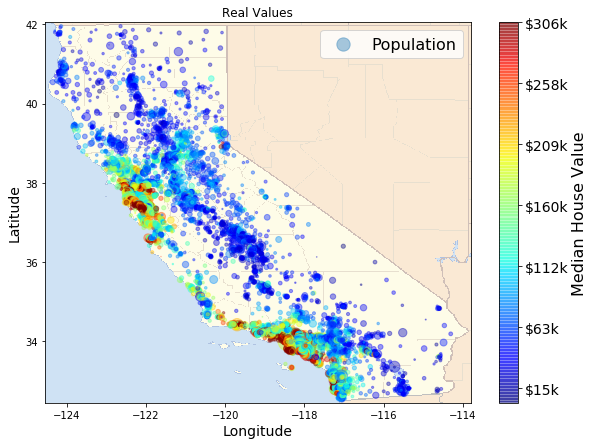

In [46]:
import matplotlib.image as mpimg

california_img=mpimg.imread('C:/Users/james/handson-ml/images/end_to_end_project/california.png')


axs = housing2.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
axs.set_title('Real Values')
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing2["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

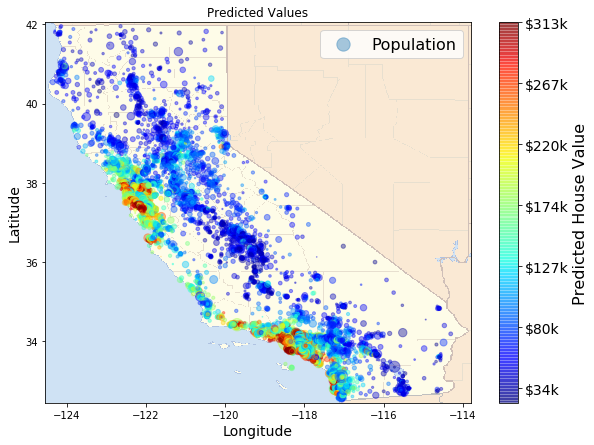

In [45]:
axs = housing3.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="pred_med_val", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
axs.set_title('Predicted Values')
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing3["pred_med_val"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Predicted House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

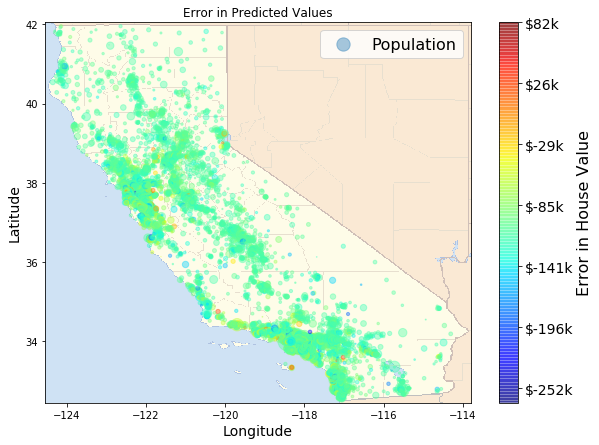

In [47]:
axs = housing4.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="Error_in_val", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
axs.set_title('Error in Predicted Values')
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing4["Error_in_val"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Error in House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()